# Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.
## Описание данных
Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).
## Постановка задачи
### [Шаг 1. Знакомство с данными, их изучение и предобработка](#section1)
- загрузить библиотеки и данные;
- оценить на распределение данных в таблице;
- выполнить ресемплирование наших данных по одному часу;
- привести в целочисленный формат количество заказов;
- вывод.
### [Шаг 2. Анализ данных](#section2)
- построить график распределения количества заказов в час за весь период;
- определить тренд;
- определить сезонность;
- остаток декомпозиции;
- оценить распределение данных и отсортировать выбивающиеся (шумные) значения;
- создание функции для добавления в выборку признаков и отстающего значения для удобства подбора параметров моделей;
- определение тестовой и тренировочной выборок;
- вывод.
### [Шаг 3. Работа с моделями:](#section3)
- создание функции для расчёта RMSE, которая будет использоваться для расчёта целевой метрики используем;
- создание функции, которая будет принимать на вход целевые и предсказанные значения, а возвращать абсолютное и среднеквадратичное отклонение на графиках с визуальным распределением разброса целевых признаков;
- создание предсказания модели LinearRegression;
- создание предсказания модели RandomForestRegressor;
- создание предсказания модели CatBoostRegressor;
- создание предсказания модели LGBMRegressor;
- создание предсказания модели DummyRegressor;
- анализ работы лучшей модели на тестовых данных;
- вывод.
### [Шаг 4. Общий вывод](#section4)


# Решение задачи
## Шаг 1. Знакомство с данными, их изучение и предобработка <a class="anchor" id="section1"></a>

Импортируем необходимые библиотеки для дальнейшей работы.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from catboost import Pool
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import warnings

warnings.filterwarnings('ignore')

RANDOM_VAL = np.random.RandomState(42)
RAND = 42

Загрузим данные.

In [2]:
try:
    taxi_data = pd.read_csv('taxi.csv')
except:
    taxi_data = pd.read_csv('/datasets/taxi.csv')

In [3]:
# Функция оценки пропусков в таблице
def pass_value_barh(data):
    try:
        (
            (data.isna().mean() * 100)
            .to_frame()
            .rename(columns={0: 'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(20, 10), legend=False, fontsize=10)
            .set_title('Пропущенные значения, %' + "\n", fontsize=22)
        )
        print('Всего значений в таблице {0}, из них пропущено от {1} до {2} значений, доля пропущенных '
              'равна от {3:.2%} до {4:.2%} в {5} столбцах.'.format(len(data),
                                                                   min(i for i in data.isna().sum() if i > 0),
                                                                   max(data.isna().sum()),
                                                                   min(i for i in data.isna().sum() if i > 0) / len(
                                                                       data),
                                                                   max(data.isna().sum()) / len(data),
                                                                   (data.isna().sum(axis=0) > 0).sum()
                                                                   ))
    except:
        print('пропусков не осталось :) ')

In [4]:
# Функция изучения данных в таблице
def research_info(data):
    rows_count, columns_count = data.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    print('Дубликатов: {}'.format(data.duplicated().sum()))
    display(data.head())
    pass_value_barh(data)

Количество стобцов: 2
Количество строк: 26496
Дубликатов: 0


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


пропусков не осталось :) 


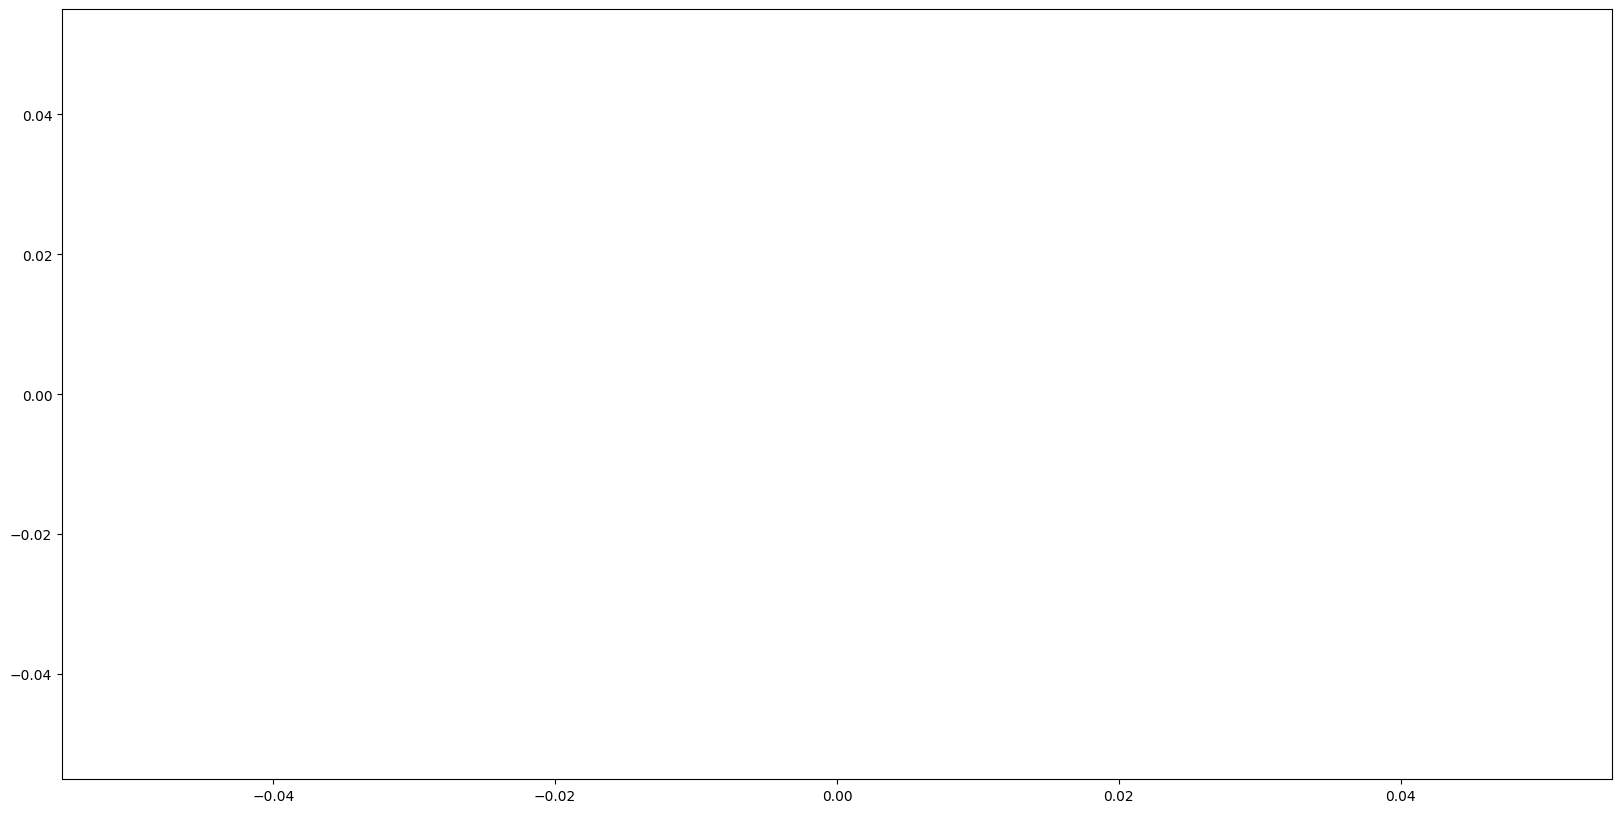

In [5]:
research_info(taxi_data)

In [6]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Что ж данные не имеют пропусков и дубликатов, а значит предобработки по восстановлению им не требуется.
Приведём столбец datetime к формату datetime64 и определим его индексом нашей таблицы

In [7]:
taxi_data['datetime'] = pd.to_datetime(taxi_data['datetime'])
taxi_data = taxi_data.set_index('datetime')
taxi_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Посмотрим на распределение данных в таблице

In [8]:
taxi_data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Выполним ресемплирование наших данных по одному часу

In [9]:
taxi_data = taxi_data.resample('1H').sum()
taxi_data = taxi_data.sort_index(ascending=True)
taxi_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Проверим, в хронологическом ли порядке расположены даты и время.

In [10]:
print(taxi_data.index.is_monotonic)

True


In [11]:
print('Такси заказывали с {} по {}'.format(min(taxi_data.index), max(taxi_data.index)))

Такси заказывали с 2018-03-01 00:00:00 по 2018-08-31 23:00:00


**Вывод:**
- данные загружены;
- пропусков нет;
- тип данных столбца `datetime` изменен с object на datetime64;
- столбец `datetime` установлен как индекс таблицы;
- данные ресемплированы по часу (изначально данные за каждые 10 минут);
- данные проверены на монотонность;
- определены временные границы датасета с 1 марта по 31 августа 2018 года.

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен. Ресемплинг был сделан верно.
</div>

## Шаг 2. Анализ данных <a class="anchor" id="section2"></a>

Построим график распределения количества заказов в час за весь период.

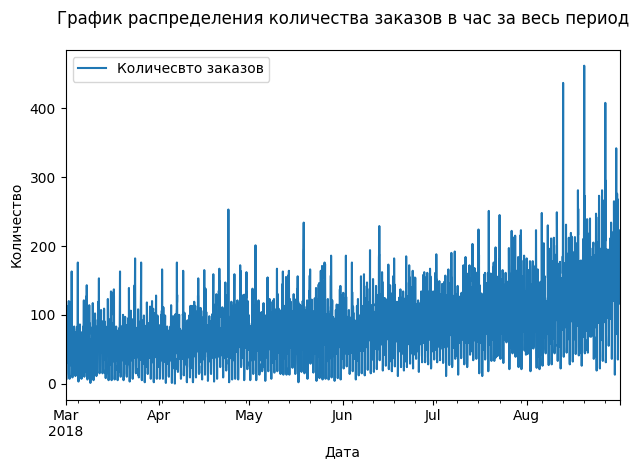

In [12]:
taxi_data.plot(ax=plt.gca())
plt.legend(['Количесвто заказов'])
plt.title('График распределения количества заказов в час за весь период', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

Красивый график, на котором, при должном старании, можно заметить рост количества заказов и некоторое количество выбросов. Постараемся определить сезонность или тренд в количестве заказов.

In [13]:
decomposed = seasonal_decompose(taxi_data)

Определим тренд.

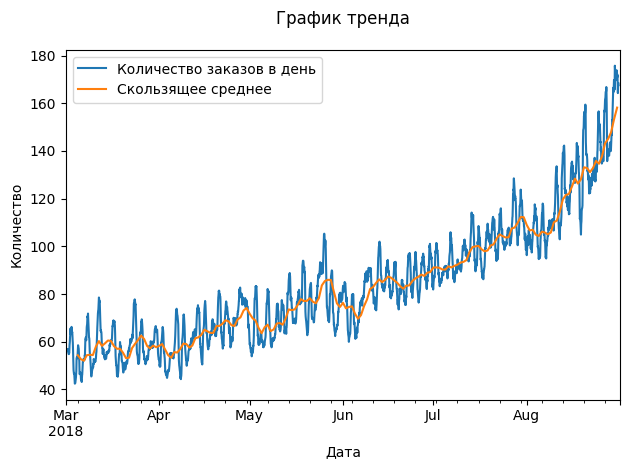

In [14]:
decomposed.trend.plot(ax=plt.gca())
decomposed.trend.resample('1D').mean().rolling(5).mean().plot(ax=plt.gca())
plt.legend(['Количество заказов в день', 'Скользящее среднее'])
plt.title('График тренда', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()

На графике можно заметить тренд к росту количества заказов в период с марта по август 2018 года.

Рассчитаем стандартное отклонение в количестве заказов за весь период.

In [15]:
print('Стандартное отклонение: {:.3f}'.format(decomposed.trend.std()))

Стандартное отклонение: 26.311


Определим сезонность для одного месяца.

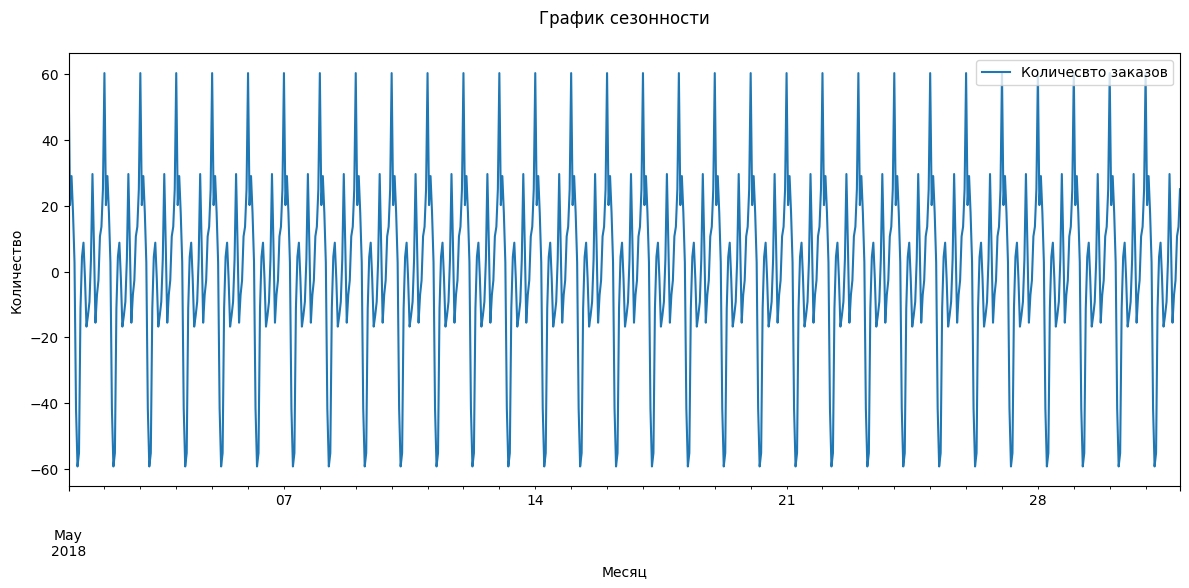

In [16]:
decomposed.seasonal['2018-05':'2018-05'].plot(ax=plt.gca(), figsize=(12, 6))
plt.legend(['Количесвто заказов'])
plt.title('График сезонности', y=1.05)
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.tight_layout()

На данном графике сезонности явно выраженный стационарный временной ряд, а также видно, что количество заказов не зависит от сезонности, возможно, у нас данные имеют слишком короткий срок для определения сезонных параметров.

Посчитаем стандартные отклонения двух отрезков времени:

In [17]:
print('Стандартное отклонение: {:.3f}'.format(decomposed.seasonal['2018-03':'2018-06'].std()))
print('Среднее значение: {:.3f}'.format(decomposed.seasonal['2018-03':'2018-06'].mean()))
print('Стандартное отклонение: {:.3f}'.format(decomposed.seasonal['2018-06':'2018-09'].std()))
print('Среднее значение: {:.3f}'.format(decomposed.seasonal['2018-06':'2018-09'].mean()))

Стандартное отклонение: 26.158
Среднее значение: 0.000
Стандартное отклонение: 26.160
Среднее значение: 0.000


Данный временной ряд имеет среднее значение и стандартное отклонение, которые не изменяются с течением времени. По этому уделим больше внимания тренду.

Посмотрим на остаток декомпозиции.

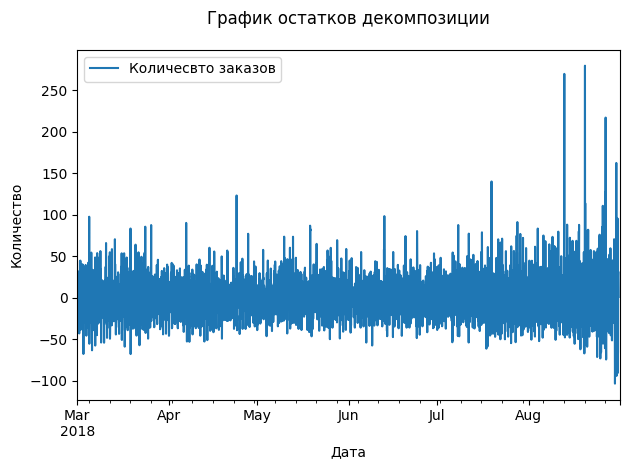

In [18]:
decomposed.resid.plot(ax=plt.gca())
plt.legend(['Количесвто заказов'])
plt.title('График остатков декомпозиции', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()

Можно заметить, что в конце августа есть всплеск выбивающихся заказов, скорее всего он связан с подготовкой к началу учебного года и возвращением из отпусков.

По тренду видно, что со временем все больше и больше людей пользуется услугой заказа такси.

Временной ряд в таком виде не является стационарным, так как подвержен тренду, который меняется во времени. Это можно подтвердить критерием Дикки-Фуллера.

In [19]:
test = sm.tsa.adfuller(taxi_data)
print('p-value: ', test[1])
if test[0] > test[4]['5%']:
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

p-value:  0.028940051402613857
Единичных корней нет, ряд стационарен


При явном наличии тренда и сезонности, критерий Дики-Фуллера не значим.
Сравним сезонность и тренды для разных временных периодов.

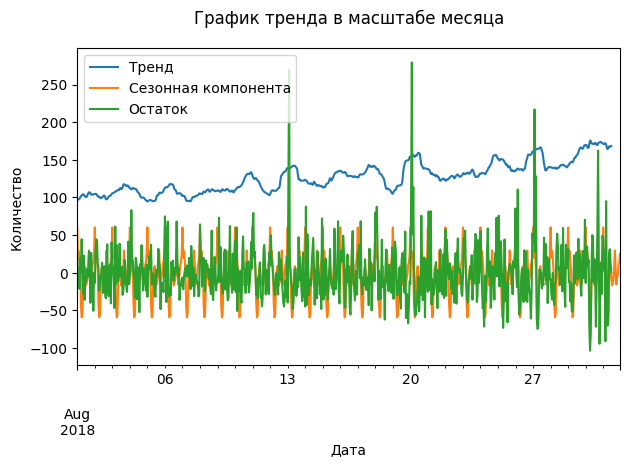

In [20]:
decomposed.trend['2018-08':'2018-08'].plot()
decomposed.seasonal['2018-08':'2018-08'].plot()
decomposed.resid['2018-08':'2018-08'].plot()
plt.legend(['Тренд', 'Сезонная компонента', 'Остаток'])
plt.title('График тренда в масштабе месяца', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()

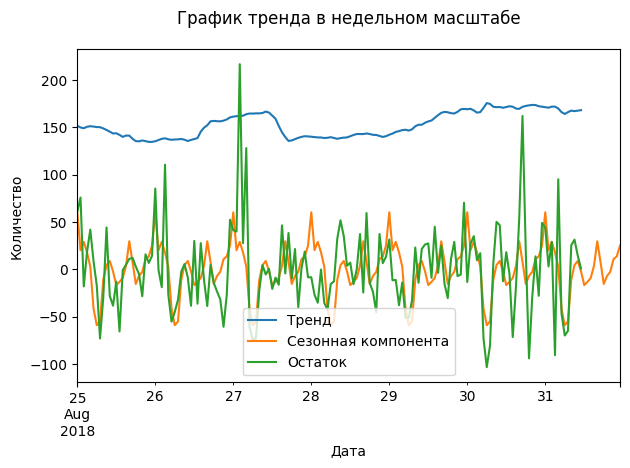

In [21]:
decomposed.trend['2018-08-25':'2018-08-31'].plot()
decomposed.seasonal['2018-08-25':'2018-08-31'].plot()
decomposed.resid['2018-08-25':'2018-08-31'].plot()
plt.legend(['Тренд', 'Сезонная компонента', 'Остаток'])
plt.title('График тренда в недельном масштабе', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()

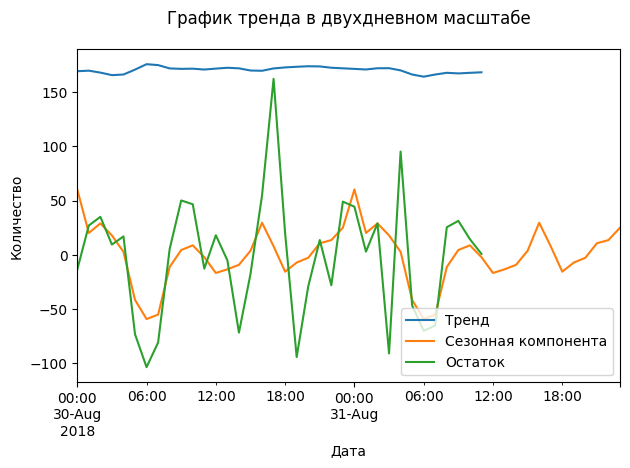

In [22]:
decomposed.trend['2018-08-30':'2018-08-31'].plot()
decomposed.seasonal['2018-08-30':'2018-08-31'].plot()
decomposed.resid['2018-08-30':'2018-08-31'].plot()
plt.legend(['Тренд', 'Сезонная компонента', 'Остаток'])
plt.title('График тренда в двухдневном масштабе', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()

Можно заметить, что такси требуются для ночных рейсов и по наступлению утра намечается спад вызовов такси.
Исследуем, какие признаки нам понадобится.
Так как видна ежедневная сезонность - то точно понадобится признак day.
Тред показывает, что к концу недели и в середине идет увеличение заказов - добавим признак dayofweek.
Из месяца в месяц данные отличаются и носят цикличный характер - добавим признак month.

Создадим признаки для задачи прогнозирования

In [24]:
# Создадим признаки для горизонта прогнозирования в 1 шаг
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.dayofweek
    # Вычислим отстающие значения, добавим новый аргумент max_lag, который задаст максимальный размер отставания.
    # Новые признаки назовем: 'lag_1', 'lag_2' — и до величины max_lag.
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    # Вычислим скользящее среднее и добавим его как признак 'rolling_mean'.
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


taxi_data_copy = taxi_data.copy()
make_features(taxi_data_copy, 28, 58)
taxi_data_copy.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Удалим строки с пропусками, появившиеся в ходе создания лаговых переменных.

In [25]:
taxi_data_copy = taxi_data_copy.dropna()

Проверим, в хронологическом ли порядке расположены даты и время, после удаления пропусков.

In [26]:
print(taxi_data_copy.index.is_monotonic)

True


Подготовка данных

In [27]:
train, test = train_test_split(taxi_data_copy, shuffle=False, test_size=0.2)
valid, test = train_test_split(test, shuffle=False, test_size=0.5)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

eval_set = [(features_valid, target_valid)]

Проверим корректность деления

In [28]:
print('Размер тренировочной выборки - {:.0%}, c {} до {}'.format(features_train.shape[0] / taxi_data.shape[0],
                                                                 features_train.index.min(),
                                                                 features_train.index.max()))

print('Размер валидационной выборки - {:.0%}, c {} до {}'.format(features_valid.shape[0] / taxi_data.shape[0],
                                                                 features_valid.index.min(),
                                                                 features_valid.index.max()))

print('Размер тестовой выборки - {:.0%}, c {} до {}'.format(features_test.shape[0] / taxi_data.shape[0],
                                                            features_test.index.min(), features_test.index.max()))

Размер тренировочной выборки - 79%, c 2018-03-03 10:00:00 до 2018-07-26 15:00:00
Размер валидационной выборки - 10%, c 2018-07-26 16:00:00 до 2018-08-13 19:00:00
Размер тестовой выборки - 10%, c 2018-08-13 20:00:00 до 2018-08-31 23:00:00


**Вывод**
В этом разделе мы проанализировали графики временного ряда, сначала по всем данным, затем по месяцу и по 2 дням и выявили тренд на увеличение количества заказов с течением времени, а также то, что максимум заказов приходится на 12 ночи, а минимум на 6 утра. Проверили на стационарность временного ряда. Затем мы создали календарные признаки для месяца, дня, дня недели и часа и отстающие признаки, а также скользящее среднее. Удалили пропуски и получили таблицу с 16 признаками, готовую для построения моделей. Так же из готовой таблицы получили набор обучающих, валидационных и тестовых данных.

## Шаг 3. Работа с моделями <a class="anchor" id="section3"></a>

Для расчёта целевой метрики используем RMSE и напишем функцию для её расчёта.

In [29]:
def rmse(test, predict):
    return ((mean_squared_error(test, predict)) ** 0.5).round(2)

Создадим функцию, которая будет принимать на вход целевые и предсказанные значения, а возвращать абсолютное и среднеквадратичное отклонение на графиках с визуальным распределением разброса целевых признаков.

In [30]:
def illustration_target(test, predict):
    plt.figure(figsize=(20, 6))
    plt.plot(test.index,
             test,
             'b-',
             test.index,
             predict,
             'r-')
    plt.title('График отношения предсказанных значений к истинным значениям', y=1.05)
    plt.xlabel('Дата')
    plt.ylabel('Количество заказов')
    plt.legend(['Истинные значения', 'Предсказанные значения'])
    plt.show()

In [31]:
# Генерация таблицы с метриками
def get_metrics(name: str = None,
                mae_metric: str = None,
                rmse_metric: str = None):
    df_metrics = pd.DataFrame()
    df_metrics['model'] = [name]
    df_metrics['MAE'] = [mae_metric]
    df_metrics['RMSE'] = [rmse_metric]
    return df_metrics

In [32]:
splits = TimeSeriesSplit(n_splits=5)

Выберем следующие регрессоры для обучения модели:

- LinearRegression;
- RandomForestRegressor;
- CatBoostRegressor;
- LGBMRegressor;
- DummyRegressor.

**1. LinearRegression**

In [33]:
model_lr = LinearRegression(normalize=True)
model_lr.fit(features_train, target_train)
predict_lr = model_lr.predict(features_valid)
predict_lr = predict_lr.round()
mae_lr = mean_absolute_error(target_valid, predict_lr)
print('MAE модели LinearRegression равна:', mae_lr.round(2))
rmse_lr = rmse(target_valid, predict_lr)
print('RMSE модели LinearRegression равна:', rmse_lr)

MAE модели LinearRegression равна: 25.13
RMSE модели LinearRegression равна: 34.42


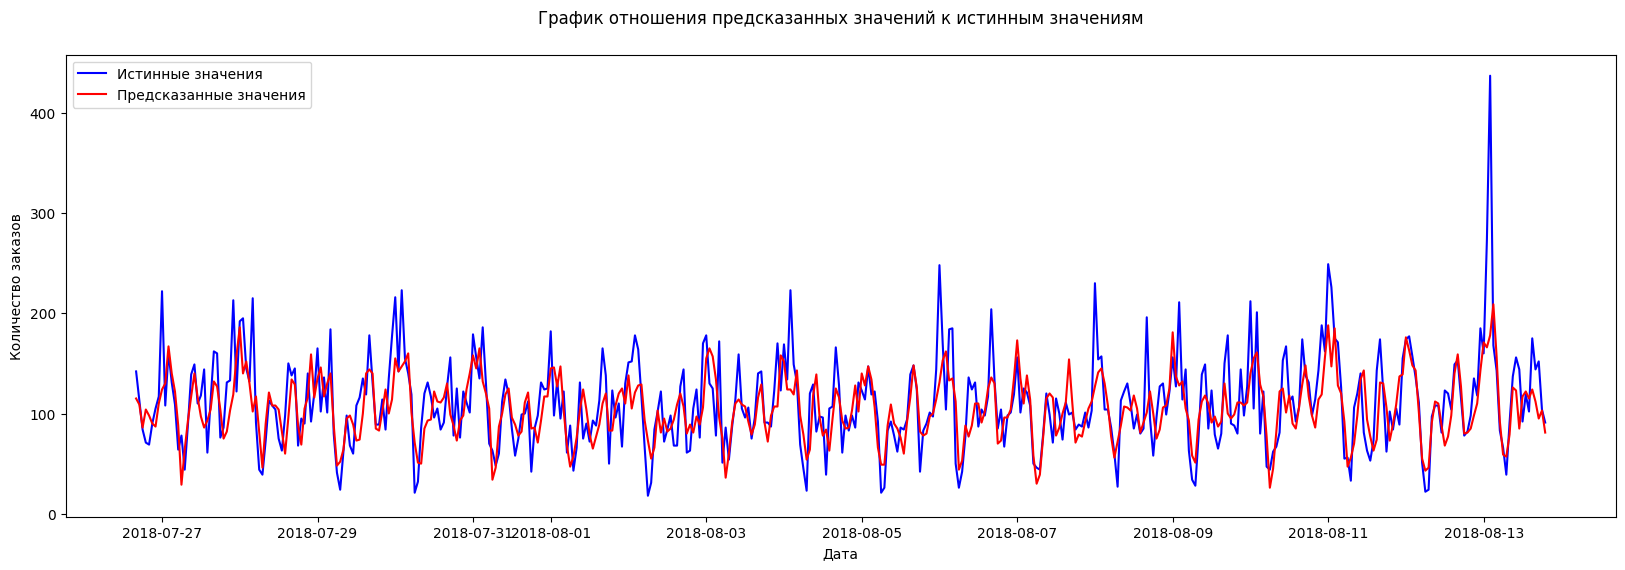

In [34]:
metrics = get_metrics('LinearRegression', mae_lr, rmse_lr)
illustration_target(target_valid, predict_lr)

**2. RandomForestRegressor**

In [35]:
model_rf = RandomForestRegressor(random_state=RANDOM_VAL)
model_rf_grid = GridSearchCV(model_rf,
                             cv=splits,
                             scoring=make_scorer(rmse, greater_is_better=False),
                             param_grid={'n_estimators': range(5, 18),
                                         'max_depth': range(9, 21)})

model_rf_grid.fit(features_train, target_train)
predict_rfr = model_rf_grid.predict(features_valid)
predict_rfr = predict_rfr.round()
mae_rfr = mean_absolute_error(target_valid, predict_rfr)
print('MAE модели RandomForestRegressor равна:', mae_rfr.round(2))
rmse_rfr = rmse(target_valid, predict_rfr)
print('RMSE модели RandomForestRegressor равна:', rmse_rfr)

MAE модели RandomForestRegressor равна: 24.03
RMSE модели RandomForestRegressor равна: 34.41


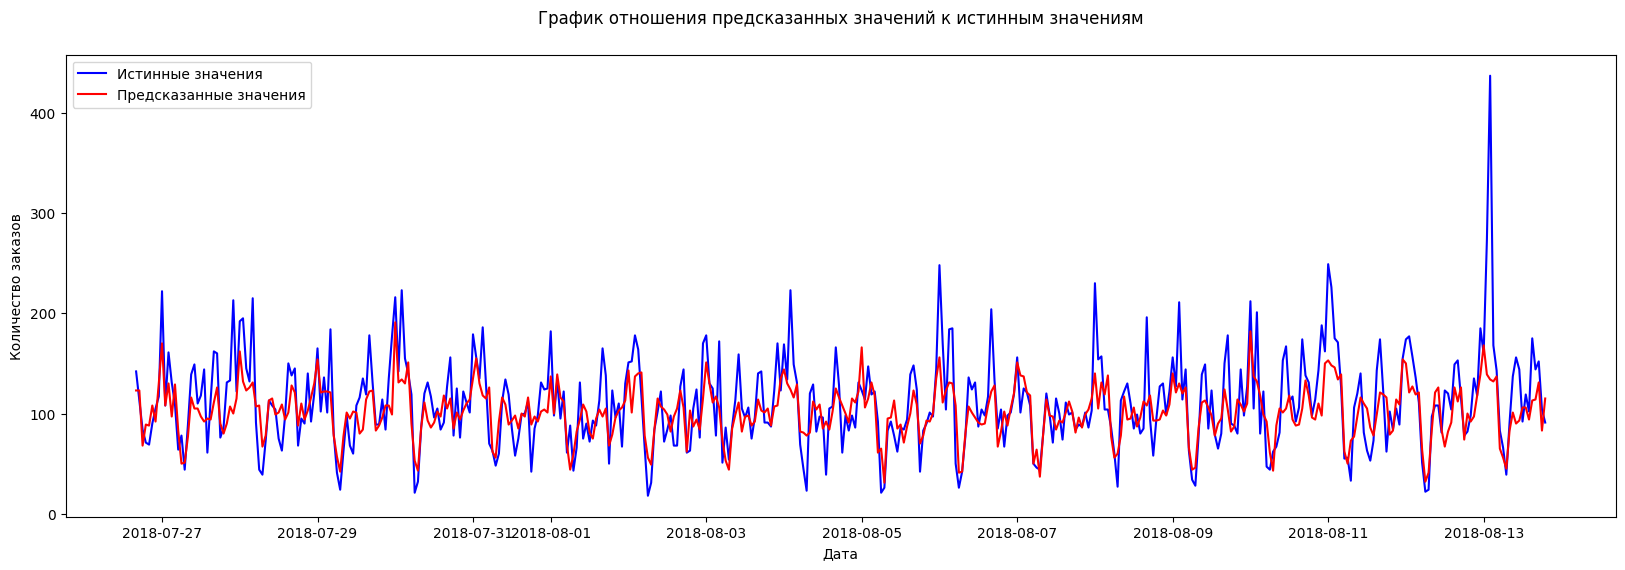

In [36]:
metrics = metrics.append(get_metrics('RandomForestRegressor', mae_rfr, rmse_rfr))
illustration_target(target_valid, predict_rfr)

**3. CatBoostRegressor**

In [37]:
model_cbr = CatBoostRegressor(random_seed=RAND,
                              loss_function='RMSE',
                              eval_metric='RMSE',
                              allow_writing_files=False)

model_cbr.fit(features_train,
              target_train,
              eval_set=eval_set,
              verbose=0,
              use_best_model=True)
predict_cbr = model_cbr.predict(features_valid)
predict_cbr = predict_cbr.round()
mae_cbr = mean_absolute_error(target_valid, predict_cbr)
print('MAE модели CatBoostRegressor равна:', mae_cbr.round(2))
rmse_cbr = rmse(target_valid, predict_cbr)
print('RMSE модели CatBoostRegressor равна:', rmse_cbr)

MAE модели CatBoostRegressor равна: 22.47
RMSE модели CatBoostRegressor равна: 31.74


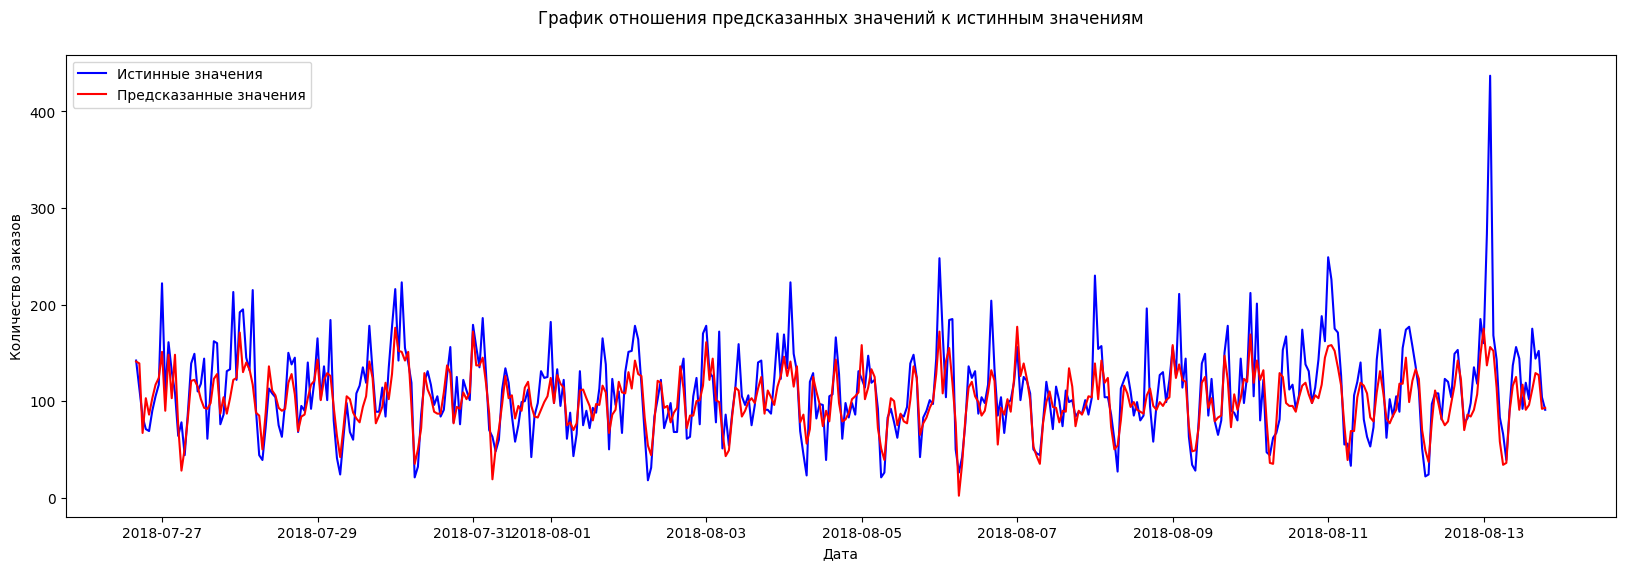

In [38]:
metrics = metrics.append(get_metrics('CatBoostRegressor', mae_cbr, rmse_cbr))
illustration_target(target_valid, predict_cbr)

**4. LGBMRegressor**

In [39]:
model_lgbmr = LGBMRegressor(random_state=RAND, objective='rmse')
model_lgbmr.fit(features_train, target_train, eval_metric='rmse',
                eval_set=eval_set,
                verbose=False,
                early_stopping_rounds=100)
predict_lgbmr = model_lgbmr.predict(features_valid)
predict_lgbmr = predict_lgbmr.round()
mae_lgbmr = mean_absolute_error(target_valid, predict_lgbmr)
print('MAE модели LGBMRegressor равна:', mae_lgbmr.round(2))
rmse_lgbmr = rmse(target_valid, predict_lgbmr)
print('RMSE модели LGBMRegressor равна:', rmse_lgbmr)

MAE модели LGBMRegressor равна: 23.6
RMSE модели LGBMRegressor равна: 33.37


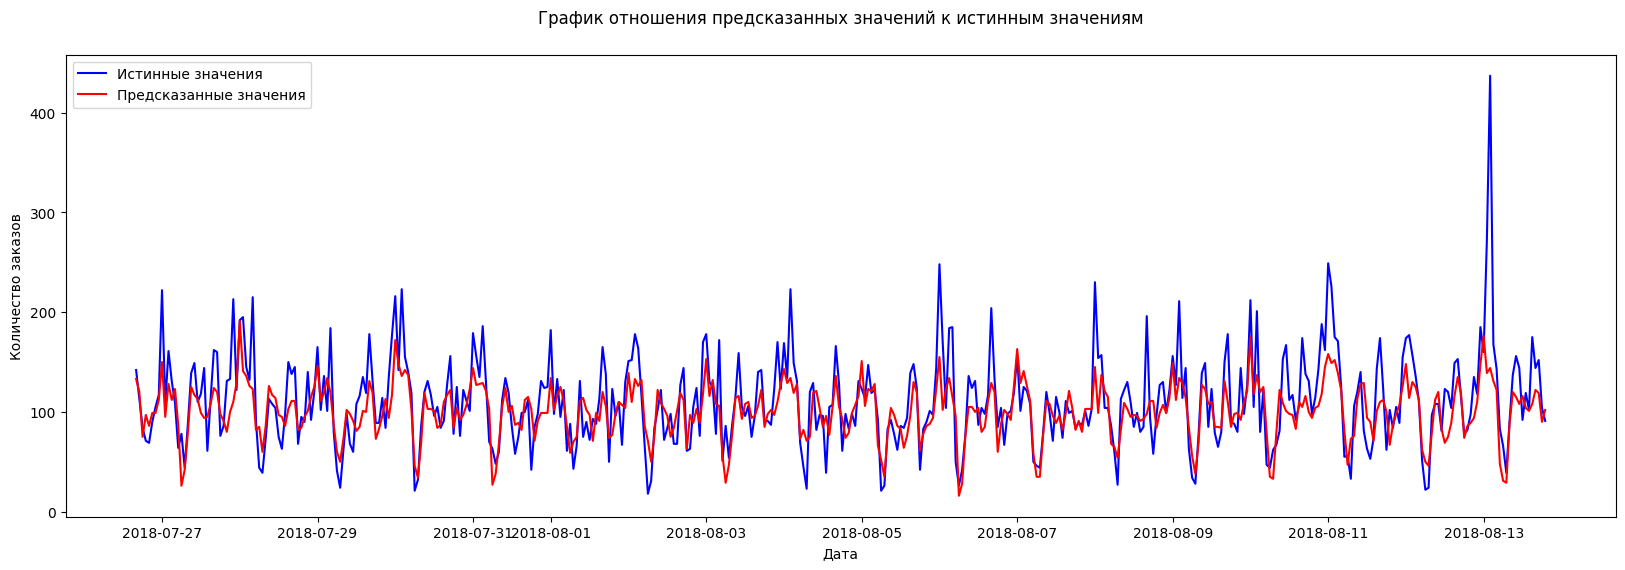

In [40]:
metrics = metrics.append(get_metrics('LGBMRegressor', mae_lgbmr, rmse_lgbmr))
illustration_target(target_valid, predict_lgbmr)

**5. DummyRegressor**

In [41]:
model_dr = DummyRegressor()
model_dr.fit(features_train, target_train)
predict_dr = model_dr.predict(features_valid)
predict_dr = predict_dr.round()
mae_dr = mean_absolute_error(target_valid, predict_dr)
print('MAE модели DummyRegressor равна:', mae_dr.round(2))
rmse_dr = rmse(target_valid, predict_dr)
print('RMSE модели DummyRegressor равна:', rmse_dr)

MAE модели DummyRegressor равна: 44.4
RMSE модели DummyRegressor равна: 58.29


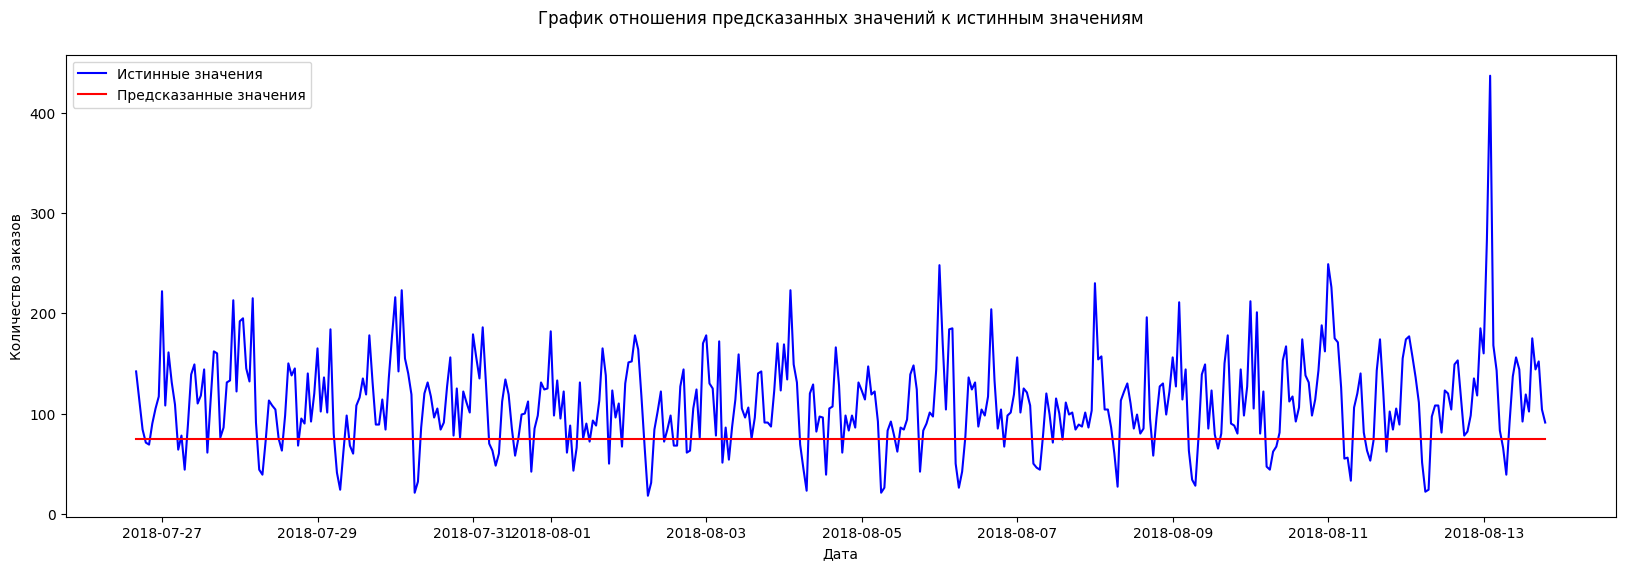

In [42]:
metrics = metrics.append(get_metrics('DummyRegressor', mae_dr, rmse_dr))
illustration_target(target_valid, predict_dr)

In [43]:
metrics = metrics.set_index('model')
metrics.style.background_gradient(cmap='coolwarm')

,MAE,RMSE
model,,
LinearRegression,25.130734,34.420000
RandomForestRegressor,24.029817,34.410000
CatBoostRegressor,22.467890,31.740000
LGBMRegressor,23.596330,33.370000
DummyRegressor,44.403670,58.290000


По графикам распределения можно заметить, что все модели справились со своей задачей не плохо, однако все модели ошибаются в меньшую сторону. Чуть лучшей моделью по качеству RMSE показала себя CatBoostRegressor. Дообучим модель на объединенных тестовых и валидационных данных и проверим качество выбранной модели на тестовых данных.

In [44]:
full_train_features = pd.concat([features_train, features_valid])
full_train_target = pd.concat([target_train, target_valid])

In [45]:
# Проверка корректности слияния датфреймов
print(full_train_features.index.is_monotonic)

True


MAE модели CatBoostRegressor равна: 30.27
RMSE модели CatBoostRegressor равна: 40.6


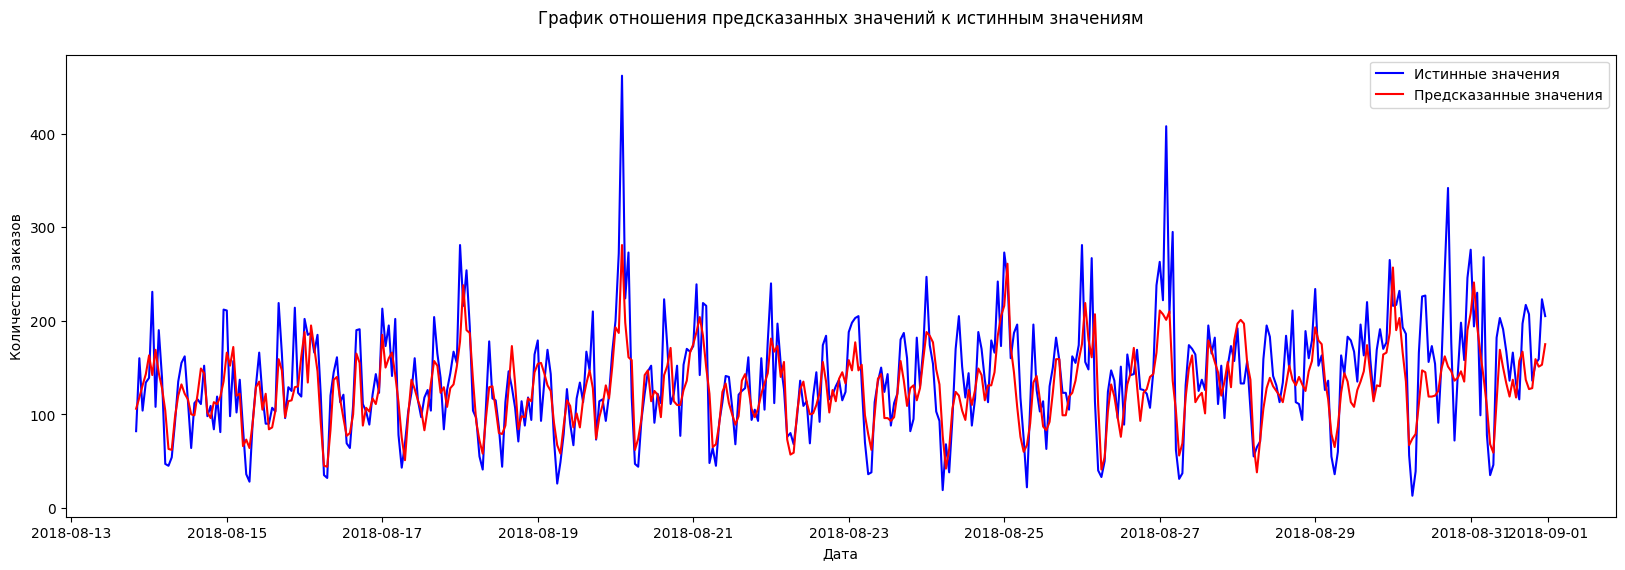

In [46]:
best_model = model_cbr
best_model.fit(full_train_features,
               full_train_target,
               verbose=False,)
predict_best = best_model.predict(features_test)
predict_best = predict_best.round()
print('MAE модели CatBoostRegressor равна:', mean_absolute_error(target_test, predict_best).round(2))
print('RMSE модели CatBoostRegressor равна:', rmse(target_test, predict_best))
illustration_target(target_test, predict_best)
predict_best = pd.Series(predict_best, index=features_test.index)

Добавим на график за целевой период времени скользящие средние значения.

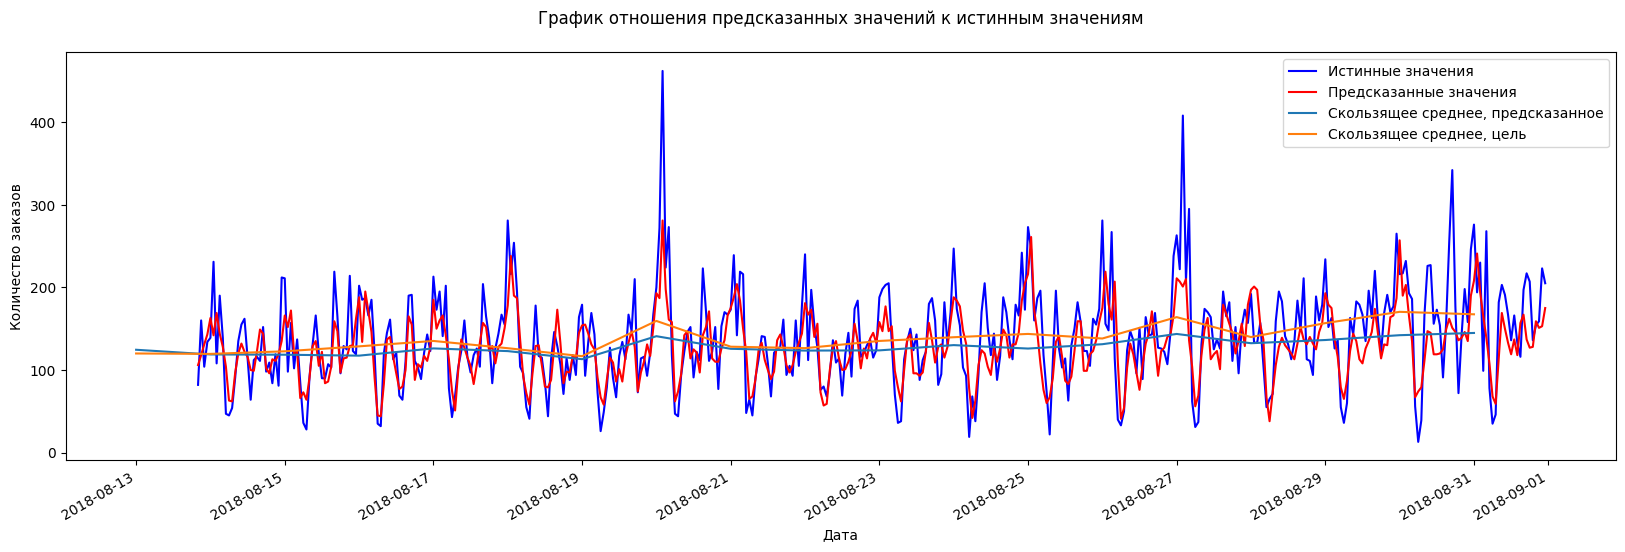

In [47]:
plt.figure(figsize=(20, 6))
plt.plot(target_test.index,
         target_test,
         'b-',
         target_test.index,
         predict_best,
         'r-')
predict_best.resample('1D').mean().rolling(1).mean().plot(ax=plt.gca())
target_test.resample('1D').mean().rolling(1).mean().plot(ax=plt.gca())
plt.title('График отношения предсказанных значений к истинным значениям', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend(
    ['Истинные значения', 'Предсказанные значения', 'Скользящее среднее, предсказанное', 'Скользящее среднее, цель'])
plt.show()

Посмотрим на временной период одного дня с распределением по часам и на предсказания нашей лучшей модели

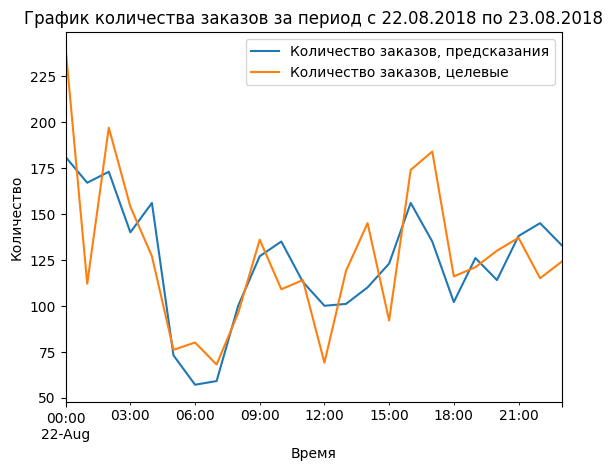

In [48]:
day1 = '2018-08-22 00:00:00'
day2 = '2018-08-22 23:00:00'
predict_best[day1:day2].plot(ax=plt.gca())
target_test[day1:day2].plot(ax=plt.gca())

plt.legend(['Количество заказов, предсказания', 'Количество заказов, целевые'])
plt.title('График количества заказов за период c 22.08.2018 по 23.08.2018')
plt.xlabel('Время')
plt.ylabel('Количество')
plt.show()

**Вывод**
Выбранная модель неплохо справляется с задачей предсказывать количество заказов с разбивкой по часам. На часовом графике это хорошо видно, к тому же можем наблюдать спад потребления в часы с 4 до 7 утра и пиковые значения под вечер. Судя по графикам такая статистика имеет ежедневный характер, что позволяет планировать загрузку и график работы таксопарка.

Таким образом было достигнуто пороговое значение метрики в 40.6 единиц и для компании «Чётенькое такси» можно рекомендовать для предсказания количества заказов такси на следующий час модель CatBoostRegressor.

## Шаг 4. Общий вывод <a class="anchor" id="section4"></a>
В ходе проделанной работы было выполнено:
1. В рамках предобработки данных:
- данные загружены и проверены на пропуски;
- столбец `datetime` установлен как индекс таблицы;
- данные ресемплированы по часу (изначально данные за каждые 10 минут) и проверены на монотонность.

2. В рамках анализа данных:
- данные проверены на стационарность временного ряда;
- получена таблица сравнительных признаков качества моделей;
- добавлены календарные признаки для месяца, дня, дня недели, часа, отстающие признаки и скользящее среднее;
- получены набор обучающих, валидационных и тестовых данных.

3. В рамках работы с различными моделями:
- обучены разные модели регрессии;
- создана сравнительная таблица признаков параметров разных моделей;
- выбрана лучшая модель;
- её качество проверено на тестовой выборке;
- модель прошла проверку DummyRegressor;
- составлен вывод и рекомендации заказчику.